# Assignment 4: Anomaly Detection with VAEs
As we have seen, Variational Autoencoders (VAEs) provide a mathematically grounded framework for the unsupervised learning of latent representations. Besides interpreting VAEs as representation learning or generative modelling, we can also see them as performing (approximate) density approximation. VAEs are trained to optimise a lower bound to the (log) likelihood $\log p(X)$ of the data $X$, under the chosen model. So, for any point in data space, we can obtain an estimate of its likelihood under the trained model, by simply computing the loss function when passing this data point through the neural network (note that the loss function is the negative ELBO, so we need to multiply by -1 to obtain a likelihood estimation).

We can use this idea to perform unsupervised anomaly detection. Suppose we are given a dataset that describes some natural distribution (e.g. images of certain clothing items). For new test data, we then wish to detect whether it fits this distribution, or is significantly different (an anomaly). For example, given a dataset of shirts, we want to detect anomalies in a test data set that also contains some images of trousers. Typically, such a situation occurs when we have many examples of one class (e.g. shirts), but very few of others (the anomalies, e.g. trousers).

In this task, we will perform and evaluate such anomaly detection with VAEs. Given a training data set that consists of instances that we consider "normal", we wish to detect anomalies in a test data set that contains both "normal" (but unseen) examples, as well as other examples which we consider anomalous. The idea is to train a VAE on the training data, such that it learns to represent "normal" data well. We can then compute the ELBO values for the test data, where ideally "normal" examples should obtain higher likelihood values than anomalous examples.

In this assignment, we will use FashionMNIST to simulate the anomaly detection task. We will omit one class from the training data, and consider the remaining 9 classes to be "normal". The goal is then to identify the omitted class in the test data, by comparing the ELBO values obtained from a VAE trained on 9 classes.

**NOTE:**
* **Only fill in the cells marked with `#### INSERT CODE HERE ####` or `<-- WRITE TEXT HERE -->`**
* **Do not add or delete any cells**
* **Make sure to run all cells before handing in.**
* **Re-running all cells in your notebook in order should produce similar output (it may vary slightly due to stochasticity in the training).**
* **You don't need to extensively comment your code, but briefly mention any assumptions you make, or any design choices.**
* **Make sure that the cell output (where needed) is clear and easy to interpret (i.e. print what it is you are outputting, captions/titles for plots).**

## Imports
These should be all the imports you'll need, please don't use any other libraries as this will make it harder to assess your work.

In [2]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import backend as K

from sklearn.metrics import roc_curve, precision_recall_curve, auc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Task 1: Obtain anomaly detection dataset
**(a)** We will consider the "Trouser" class (with label 1) to be the anomalies, and consider the other 9 classes to be our "normal" data. We'll train on normal data only, but we want to test on both normal and anomalous data to evaluate our anomaly detection framework.
* Load the FashionMNIST dataset.
* Remove all instances from the anomaly class from the training set.
* Split the test set in two parts: the anomalous data (with label 1) and the normal data (all other labels).

*Implementation hint: `np.argwhere` may be helpful for splitting the data based on its labels.*

In [ ]:
#### INSERT CODE HERE ####
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


# Remove all instances from the anomaly class from the training set.
normal_index_train = np.argwhere(y_train!=1)
x_train_normal = np.squeeze(x_train[normal_index_train])
y_train_normal = np.squeeze(y_train[normal_index_train])

# save the data for plotting
x_train_normal_plot = x_train_normal

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_train_normal = x_train_normal.reshape(x_train_normal.shape + (1,))

# pad zeros to obtain canvas size of 32x32, i.e. shape is now (n, 32, 32, 1)
x_train_normal = np.pad(x_train_normal, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

# normalise
x_train_normal = x_train_normal.astype('float32') / 255
y_train_normal = y_train_normal.astype('float32') / 255

print('x_train_normal shape', x_train_normal.shape)
print('y_train_normal shape', y_train_normal.shape)


# Split the test set in two parts: the anomalous data (with label 1) and the normal data (all other labels)
normal_index_test = np.argwhere(y_test!=1)
anomalies_index_test = np.argwhere(y_test==1)
x_test_normal = np.squeeze(x_test[normal_index_test])
y_test_normal = np.squeeze(y_test[normal_index_test])

x_test_anomalies = np.squeeze(x_test[anomalies_index_test])
y_test_anomalies = np.squeeze(y_test[anomalies_index_test])

# save the data for plotting
x_test_normal_plot = x_test_normal
x_test_anomalies_plot = x_test_anomalies

# change shape: (n, 28, 28) -> (n, 28, 28, 1)
x_test_normal = x_test_normal.reshape(x_test_normal.shape + (1,))
x_test_anomalies = x_test_anomalies.reshape(x_test_anomalies.shape + (1,))

# pad zeros to obtain canvas size of 32x32, i.e. shape is now (n, 32, 32, 1)
x_test_normal = np.pad(x_test_normal, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)
x_test_anomalies = np.pad(x_test_anomalies, pad_width=((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant", constant_values=0)

# normalise
x_test_normal = x_test_normal.astype('float32') / 255
y_test_normal = y_test_normal.astype('float32') / 255

x_test_anomalies = x_test_anomalies.astype('float32') / 255
y_test_anomalies = y_test_anomalies.astype('float32') / 255

print('x_test_normal shape', x_test_normal.shape)
print('y_test_normal shape', y_test_normal.shape)
print('x_test_anomalies shape', x_test_anomalies.shape)
print('y_test_anomalies shape', y_test_anomalies.shape)

x_train_normal shape (54000, 32, 32, 1)
y_train_normal shape (54000,)
x_test_normal shape (9000, 32, 32, 1)
y_test_normal shape (9000,)
x_test_anomalies shape (1000, 32, 32, 1)
y_test_anomalies shape (1000,)


**(b)** To check if the split was done correctly, plot some random examples (at least 10 each) of:
* The new training set (without the anomaly class)
* The normal test set
* The anomaly test set

The new training set (without the anomaly class):


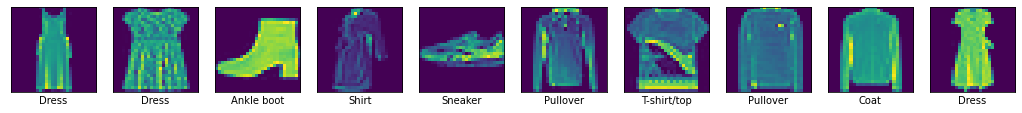

The normal test set:


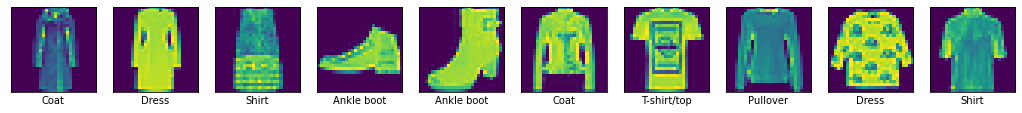

The anomaly test set:


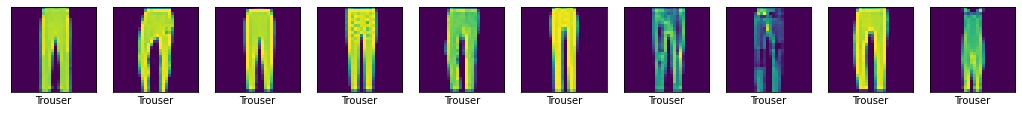

In [ ]:
#### INSERT CODE HERE ####

# choose random images for each set
train_indices = np.random.randint(0, 54000-1, size=10)
normal_test_indices = np.random.randint(0, 9000-1, size=10)
anomaly_test_indices = np.random.randint(0, 1000-1, size=10)


# for labeling the printed images
classes = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}


# print the images
print('The new training set (without the anomaly class):')
j=0
plt.figure(figsize=(18,18))
for i in train_indices:
    j=j+1
    plt.subplot(1, 10, j)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_normal_plot[i])
    plt.viridis()
    plt.xlabel(classes[(y_train_normal[i]*255).astype('int')])
plt.show()


print('The normal test set:')
j=0
plt.figure(figsize=(18,18))
for i in normal_test_indices:
    j=j+1
    plt.subplot(1, 10, j)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_normal_plot[i])
    plt.viridis()
    plt.xlabel(classes[(y_test_normal[i]*255).astype('int')])
plt.show()


print('The anomaly test set:')
j=0
plt.figure(figsize=(18,18))
for i in anomaly_test_indices:
    j=j+1
    plt.subplot(1, 10, j)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_anomalies_plot[i])
    plt.viridis()
    plt.xlabel(classes[(y_test_anomalies[i]*255).astype('int')])
plt.show()

## Task 2: Design, implement, and train a VAE
**(a)** Design a VAE for the FashionMNIST dataset with a suitable architecture, that should perform well on this dataset.
* Implement the VAE (with corresponding loss functions) and compile it.
* Print a summary (with `.summary()`) of the encoder and decoder.

*Hint: in Practical 6.1 we used a latent dimension of 2 because it allows for nice latent space plots. This limits the capacity of the VAE however, so here you will want to choose a higher number.*

In [ ]:
#### INSERT CODE HERE ####

# get training shape
n_train, height, width, depth = x_train_normal.shape    #54000, 32, 32, 1



latent_dim = 18



## Enconder ##

# input
x_in = layers.Input(shape=(height, width, depth), name="encoder_input")

# conv block 1
conv1 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same",
                  activation='relu')(x_in)                    # (32, 32, 1)  -> (32, 32, 64)
mp1 = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(conv1)  # (32, 32, 64) -> (16, 16, 64)
bn1 = layers.BatchNormalization()(mp1)                            # no change

# conv block 2
conv2 = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same",
                  activation='relu')(bn1)                       # (16, 16, 64)  -> (16, 16, 128)
mp2 = layers.MaxPooling2D(pool_size=(2, 2), padding="same")(conv2)  # (16, 16, 128) -> (8, 8, 128)
bn2 = layers.BatchNormalization()(mp2)                            # no change

# dense layers
f = layers.Flatten()(bn2)                                       # (8, 8, 128) -> (8*8*128,)
d1 = layers.Dense(256, activation="relu")(f)                   # (8*8*128,)  -> (256,)
bn3 = layers.BatchNormalization()(d1)                            # no change
d2 = layers.Dense(128, activation="relu")(bn3)                   # (256,) -> (128,)
bn4 = layers.BatchNormalization()(d2)                            # no change

z_mu = layers.Dense(latent_dim, name="z_mu")(bn4)                 # (128,) -> (32,) (encoding dimension)
z_log_sigma = layers.Dense(latent_dim, name="z_log_sigma")(bn4)
# NOTE: no activation for the last layer, encoded representations are vectors of real numbers

# instantiate encoder model
encoder = Model(x_in, [z_mu, z_log_sigma], name='encoder')
# encoder.summary()




## Decoder ##
dec_in = layers.Input(shape=(latent_dim,), name='dec_in')
# encoded = layers.Concatenate(axis=0)([z_mu, z_log_sigma])
# print(encoded.shape)

# reverse dense layers:
d_d1 = layers.Dense(128, activation="relu")(dec_in)    # (32,) -> (128,) (encoding dimension)
d_bn1 = layers.BatchNormalization()(d_d1)    # no change
d_d2 = layers.Dense(256, activation="relu")(d_bn1)    # (128, -> (256,)
d_bn2 = layers.BatchNormalization()(d_d2)    # no change ie (256,)
d_d3 = layers.Dense(8192, activation="relu")(d_bn2)    # (256,) -> (8*8*128,)
d_d3_reshaped = layers.Reshape((8,8,128))(d_d3)    # (8*8*128,) -> (8, 8, 128)

#    reverse conv block 2:
d_bn3 = layers.BatchNormalization()(d_d3_reshaped)    # no change
up1 = layers.UpSampling2D(size=(2, 2))(d_bn3)    # (8, 8, 128  ) -> (16, 16, 128)
d_conv1 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same",
                        activation='relu')(up1)                          # (16, 16, 128) -> (16, 16, 64)

#    reverse conv block 1:
d_bn4 = layers.BatchNormalization()(d_conv1)# no change
up2 = layers.UpSampling2D(size=(2, 2))(d_bn4)# (16, 16, 64) -> (32, 32, 64)
dec_mean = layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same",
                        activation='sigmoid')(up2)# (32, 32, 64) -> (32, 32, 1)

# instantiate decoder model
decoder = Model(dec_in, dec_mean, name='decoder')
# decoder.summary()



## VAE ##

class GaussianSampling(layers.Layer):
    def call(self, inputs):
        z_mu, z_log_sigma = inputs
        epsilon = K.random_normal(shape=(K.shape(z_mu)), mean=0, stddev=1)
        return epsilon * K.exp(z_log_sigma) + z_mu

# use reparametrisation trick to sample from q(z|x)
z_sample = GaussianSampling(name="z_sample")([z_mu, z_log_sigma])


x_mean = decoder(z_sample)
vae = Model(x_in, x_mean, name='VAE')
vae.summary()



## Define Loss ##

# flatten x_in and x_mean to shape to (batch_size, n_pixels)
# don't run the following two lines twice!
x_in_flat = K.batch_flatten(x_in)
x_mean_flat = K.batch_flatten(x_mean)

# fixed value for the standard deviation of p(x|z):
x_std = (1 / np.sqrt(2)).astype(np.float32)  # float32 to match Keras Tensors

# loss terms
reconstruction_loss = K.sum(K.square(x_in_flat - x_mean_flat) / (2 * x_std**2) +
                            K.log(x_std) + 0.5 * K.log(2 * np.pi), axis=-1)
kl_loss = 0.5 * K.sum(K.square(z_mu) + K.exp(2 * z_log_sigma) - 2 * z_log_sigma - 1, axis=-1)

# combine both losses
vae_loss = reconstruction_loss + kl_loss
vae.add_loss(vae_loss)
vae.compile(optimizer="adam")

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 16, 16, 64)   256         max_pooling2d_2[0][0]            
________________________________________________________________________________________________

**(b)** Train the VAE on the FashionMNIST training dataset without the anomaly class. Make sure that you train long enough such that the loss is no longer going down. Make sure that the training output is printed (use the default `verbose` setting in `.fit`).

In [ ]:
#### INSERT CODE HERE ####

batch_size = 100
epochs = 50

# train the autoencoder
vae.fit(x_train_normal,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_normal, None))

Epoch 1/50
540/540 [==============================] - 8s 16ms/step - loss: 644.6082 - val_loss: 826.7698
Epoch 2/50
540/540 [==============================] - 8s 15ms/step - loss: 620.0312 - val_loss: 76460875776.0000
Epoch 3/50
540/540 [==============================] - 8s 15ms/step - loss: 617.1765 - val_loss: 44436832256.0000
Epoch 4/50
540/540 [==============================] - 8s 15ms/step - loss: 615.7065 - val_loss: 35655.1562
Epoch 5/50
540/540 [==============================] - 8s 15ms/step - loss: 614.7018 - val_loss: 132080.1562
Epoch 6/50
540/540 [==============================] - 8s 15ms/step - loss: 614.0085 - val_loss: 636.5464
Epoch 7/50
540/540 [==============================] - 8s 15ms/step - loss: 613.4902 - val_loss: 614.3005
Epoch 8/50
540/540 [==============================] - 8s 15ms/step - loss: 613.1140 - val_loss: 612.9937
Epoch 9/50
540/540 [==============================] - 8s 15ms/step - loss: 612.9260 - val_loss: 612.1592
Epoch 10/50
540/540 [=============

## Task 3: Inspect VAE performance
Qualitatively inspect if the VAE is trained well. The latent space plots we saw in the practical only work for 2-dimensional latent spaces, but you may need to increase the dimensionality of the latent space for good performance. Therefore we'll make some plots that work for higher-dimensional latent spaces as well; reconstructions and random samples:

* __Reconstructions:__ Take a random sample of normal training images (at least 10), and use the VAE to obtain their reconstructions. Plot both originals and reconstructions, on top of each other.
* __Random samples:__ Randomly generate some images (at least 10) with the VAE; i.e. sample latent variables from the prior distribution, and decode them into data space. Plot the results.

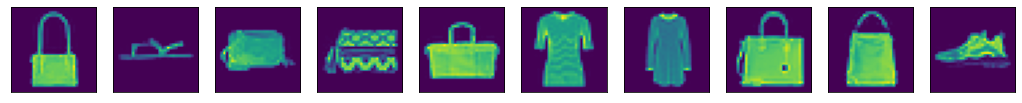

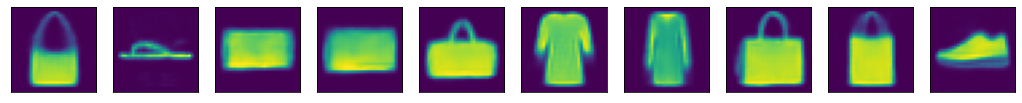

In [ ]:
#### INSERT CODE HERE ####

# choose random images for train set
train_indices = np.random.randint(0, 54000-1, size=10)
imgs = x_train_normal[train_indices]
reconstr_imgs = vae.predict(imgs)

#plot the reconstructed and original images
plt.figure(figsize=(18, 18))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(imgs[i].reshape(32, 32))
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(18, 18))
for i in range(10):
    # display reconstruction
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(reconstr_imgs[i].reshape(32, 32))
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Task 4: Anomaly detection
**(a)** Use the VAE to obtain density/likelihood estimations for the normal and anomalous test sets, i.e. compute the ELBO (the negative of the loss function) for all points in both test sets. Make sure to keep the scores for the normal and anomaly sets separate from each other.

*Implementation hint: Unfortunately, Keras's `.evaluate()` does not allow to access the loss values of individual samples, it only returns the average loss over the entire input. A simple (but slow) workaround is to just use for loops over the entire input and use `.evaluate()` for each data point individually (set `verbose=0` to avoid a long output).*

In [ ]:
#### INSERT CODE HERE ####
test_normal_eblo = []
for i in x_test_normal:
    eblo = -vae.evaluate(i.reshape(1, height, width, depth), verbose=0)
    test_normal_eblo.append(eblo)

test_anomalies_eblo = []
for i in x_test_anomalies:
    eblo = -vae.evaluate(i.reshape(1, height, width, depth), verbose=0)
    test_anomalies_eblo.append(eblo)



## pickle the computed EBLO lists
# import pickle

# path_normal = os.path.join("drive","My Drive","Colab Notebooks","DeepLearning","Assignment4","test_normal_eblo.p")
# pickle.dump(test_normal_eblo, open(path_normal, "wb" ) )

# path_anomalies = os.path.join("drive","My Drive","Colab Notebooks","DeepLearning","Assignment4","test_anomalies_eblo.p")
# pickle.dump(test_anomalies_eblo, open(path_anomalies, "wb" ) )



# # To load the two pickled lists
# import pickle

# path_normal = os.path.join("drive","My Drive","Colab Notebooks","DeepLearning","Assignment4","test_normal_eblo.p")
# load_test_normal_eblo = pickle.load(open( path_normal, "rb" ))

# path_anomalies = os.path.join("drive","My Drive","Colab Notebooks","DeepLearning","Assignment4","test_anomalies_eblo.p")
# load_test_anomalies_eblo = pickle.load(open( path_anomalies, "rb" ))

# # double check the lists are loaded correctly
# print(len(load_test_normal_eblo))       #should be 9000
# print(len(load_test_anomalies_eblo))     #should be 1000

**(b)** Visualise the scores in a histogram (`plt.hist()`) as well as a density plot (`sns.kdplot` from the `seaborn` library). Use two different colours: **green** for normal data, **red** for anomalous data, and show both normal and anomalous scores in the same plot (use transparency to make visualisation clearer), i.e. one figure with both histograms, and one figure with both density plots.

Histogram:


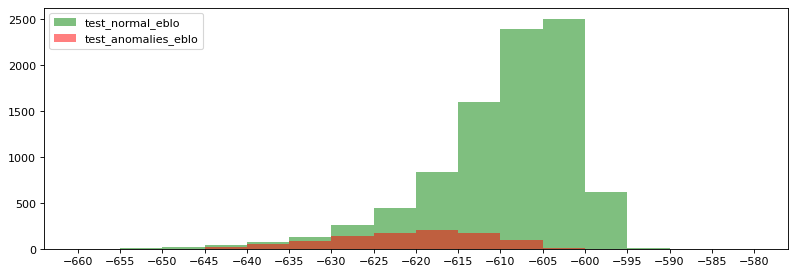

Density plot:


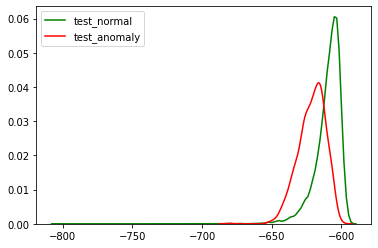

In [9]:
#### INSERT CODE HERE ####

print('Histogram:')
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.hist(test_normal_eblo, alpha=0.5, label='test_normal_eblo', color = 'green',bins=np.arange(-660, -580 + 5, 5))
plt.hist(test_anomalies_eblo, alpha=0.5, label='test_anomalies_eblo', color='red', bins=np.arange(-660, -580 + 5, 5))
plt.xticks(np.arange(-660, -580 + 5, 5))
plt.legend(loc='upper left')
plt.show()

print('Density plot:')
sns.kdeplot(test_normal_eblo, color='green', label = 'test_normal')
sns.kdeplot(test_anomalies_eblo, color='red', label = 'test_anomaly')

**(c)** Given these likelihood scores, we can choose a threshold and classify all instances with a likelihood below the threshold as anomalies, and all instances with a likelihood above the threshold as "normal". Different thresholds will give different True/False Positive/Negative scores. We can summarise the performance of all thresholds in an ROC curve, or a Precision-Recall curve (the latter has been shown to be more suitable for imbalanced datasets, see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/).
* Plot an ROC curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.
* Plot a Precision-Recall curve for your results, compute and show the Area Under Curve (AUC) score for quantitative evaluation.

*Implementation hints:*
* *See https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ for more information about ROC and PR curves and their implementation with `sklearn`.*
* *ROC/PR curves are typically used for binary classification. You can define anomaly as label 0 and normal as 1, and rescale the ELBO scores from part (a) to be between 0 and 1 (by using the minimum and maximum values in your ELBO results) to express them as binary classification probabilities.*

AUC for ROC (No skill) =  0.5
AUC for ROC (Logistic) =  0.8345378333333333


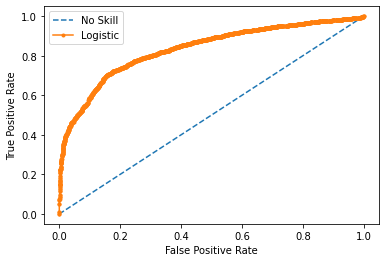

AUC for PR (Logistic) =  0.9782080561361288


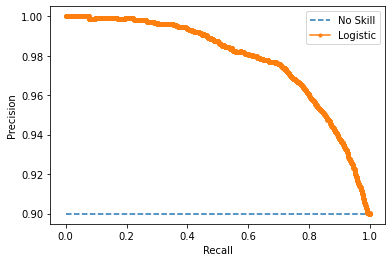

In [ ]:
#### INSERT CODE HERE ####

# label y for ROC and PR
y_normal = [1]*len(test_normal_eblo)
y_anomalies = [0]*len(test_anomalies_eblo)
y = y_normal + y_anomalies

# probs for ROC and PR
all_eblo = test_normal_eblo + test_anomalies_eblo
diff = max(all_eblo) - min(all_eblo)
probs = (np.array(all_eblo)-min(all_eblo))/diff




## ROC
ns_probs = [0]*len(y)

ns_fpr, ns_tpr, ns_thresholds = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y, probs)

# calculate AUC scores for ROC
ns_auc = auc(ns_fpr, ns_tpr)
lr_auc = auc(lr_fpr, lr_tpr)
print('AUC for ROC (No skill) = ', ns_auc)
print('AUC for ROC (Logistic) = ', lr_auc)


# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()





##PR
precision, recall, thresholds = precision_recall_curve(y, probs)

# calculate the AUC value for PR
auc_val = auc(recall, precision)
print('AUC for PR (Logistic) = ', auc_val)

# plot the precision-recall curves
no_skill = len(test_normal_eblo) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

**(d)** Ideally, a successful VAE for anomaly detection should represent (and thus reconstruct) normal data very well, but not anomalous data. Reconstruct some random images (at least 10 each) from the normal test set, as well as from the anomaly test set. Show the original images and their reconstructions on top of each other.

Original and reconstructed images for normal test set:


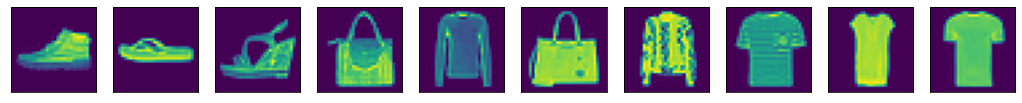

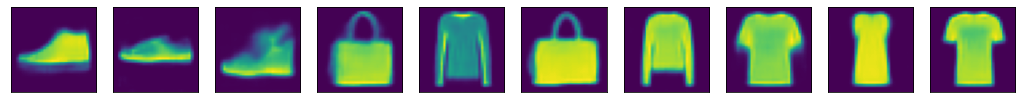

Original and reconstructed images for anomaly test set:


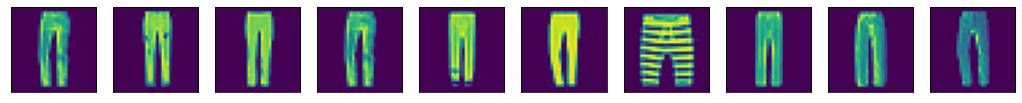

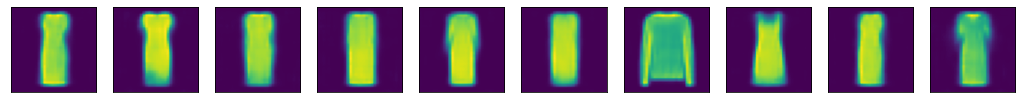

In [ ]:
#### INSERT CODE HERE ####

# choose random images for train set
test_normal_indices = np.random.randint(0, 9000-1, size=10)
test_anomalies_indices = np.random.randint(0, 1000-1, size=10)

normal_imgs = x_test_normal[test_normal_indices]
reconstr_normal_imgs = vae.predict(normal_imgs)

anomalies_imgs = x_test_anomalies[test_anomalies_indices]
reconstr_anomalies_imgs = vae.predict(anomalies_imgs)


# plot the reconstructed and original images for NORMAL test set
print('Original and reconstructed images for normal test set:')
plt.figure(figsize=(18, 18))
for i in range(10):
    # display original
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(normal_imgs[i].reshape(32, 32))
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(18, 18))
for i in range(10):
    # display reconstruction
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(reconstr_normal_imgs[i].reshape(32, 32))
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# plot the reconstructed and original images for ANOMALIES test set
print('Original and reconstructed images for anomaly test set:')
plt.figure(figsize=(18, 18))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(anomalies_imgs[i].reshape(32, 32))
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(18, 18))
for i in range(10):
    # display reconstruction
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(reconstr_anomalies_imgs[i].reshape(32, 32))
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**(e)** Give a detailed discussion of your results; does the anomaly detection perform well? Why do you think so? What could be improved? Discuss each of the results from parts (b), (c), and (d) separately.

(b) From the histogram, we can see that the likelihood estimations for normal images are mostly concentrated in the -610 to -600 range, while the stimations for anomaly images are spread out, with the highest frequency occurs between -620 to -615 range. This shows that the model predicts higher likelihood for normal images, which is a desired result. The density plots confirm this inspection. For the normal images, the plot is more skewed towards the higher values, and the distrbution for normal data is also more concentrated than the distribution for anomoly data. This means that the model is more certain of its predictions for the normal data, and less certain for the anomoly data.
<br><br>
(c) Since we have an imbalanced dataset, with much more Positives than Negatives, the PR Curve is a better way to evaluate the model's performance. As seen, Precision decreases as Recall increases and vice versa. This means, False Positive increase as False Negatives decrease and vice versa. The best trade-off for PR curve occurs at a precision of 0.97 and a recall of 0.7. The high AUC value for PR curve means that we have a good balance between precision and recall.
<br><br>
(d) From the reconstructed images, we can see that the model contructs the normal data very well, with only minor omission of details, it is able to grasp the structure of the items. Whereas for anomaly images, the model is unable to construct the object, it still tries to use the distribution of normal data to fit the anomoly data. This means that the model has learnt the distribution of the training data to some degree.